In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from utils.matrix_builder import create_expanded_feature_matrix

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Debug parameter
DEBUG = False

if DEBUG:
    print("Debug mode is ON. Detailed output will be printed.")

# Load Database
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Define the Sliding Windows for this run
sliding_window = 10 # of days to train on (matrix rows)
lag_price_window = 3  # Window of the number of previous days as features (matrix columns)

training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

# Calculate number of sliding window models to train in the dataset
num_sliding_windows = len(df) - training_sliding_window
if DEBUG:
    print(f"Number of rows in the dataset: {len(df)}")

print(f"Number of sliding windows to train: {num_sliding_windows}")

# Display the first few rows of the DataFrame
# print(f"Database:\n{df.head()}")

# If you want to extend this to a full loop over multiple windows:
# Full sliding window loop example:
predictions_list = []
actuals_list = []
timestamps_list = []
best_alpha_list = []  # Initialize the list to store best alphas

alpha_list = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0]

model = Lasso()

for i in range(num_sliding_windows):
    if DEBUG:
        print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

    # Ensure we do not exceed the DataFrame length
    if i + training_sliding_window >= len(df):
        break  # Avoid index out of bounds
    
    sliding_window_set = df.iloc[i : i + training_sliding_window]
    
    # Create feature matrix and target variable for training
    X_train, y_train = create_expanded_feature_matrix(sliding_window_set, lag_price_window)
    
    # Split for training and prediction
    X_train_fit = X_train.iloc[:-1]
    y_train_fit = y_train.iloc[:-1]

    X_to_predict = X_train.iloc[-1:]
    y_to_predict = y_train.iloc[-1]

    # Scale features for better convergence
    scaler = StandardScaler()
    X_train_fit_scaled = scaler.fit_transform(X_train_fit)
    X_to_predict_scaled = scaler.transform(X_to_predict)
    
    lowest = float('inf')
    best_alpha = None
    y_predicted = None

    # Fit and predict for each alpha in the list
    for j in range(len(alpha_list)):
        model.set_params(alpha=alpha_list[j]).fit(X_train_fit_scaled, y_train_fit)
        nl_y_prediction = model.predict(X_to_predict_scaled)
        
        # Add bounds checking to catch extreme predictions
        # high bound 1000, low bound 0
        if nl_y_prediction[0] < 0:
            # set as 0, avoiding negative predictions
            nl_y_prediction[0] = 0

        if abs(nl_y_prediction[0]) > 1000:  # Reasonable price bounds
            continue  # Skip this alpha if prediction is unrealistic
    
        # Calculate the mean absolute error
        actual = mean_absolute_error([y_to_predict], nl_y_prediction)

        if DEBUG:
            print(f"Iteration {j}, Alpha: {alpha_list[j]}, MAE: {actual}")
            print(actual)
        if actual < lowest:
            lowest = actual
            best_alpha = alpha_list[j]
            # Store the best prediction and alpha at this iteration
            y_predicted = nl_y_prediction

            if DEBUG:
                print(f"New best alpha found: {best_alpha} with MAE: {lowest}")
            
    # Add best alpha to a list for later use
    best_alpha_list.append(best_alpha)

    if DEBUG:
        print(f"Best Alpha for sliding window {i}: {best_alpha} with MAE: {lowest}")
    
    # Store results
    predictions_list.append(y_predicted[0])
    actuals_list.append(y_to_predict)
    if 'Datetime' in sliding_window_set.columns:
        timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
    else:
        timestamps_list.append(i + training_sliding_window - 1)

# Create final prediction DataFrame
prediction_df = pd.DataFrame({
    'Timestamp': timestamps_list,
    'Predicted': predictions_list,
    'Actual': actuals_list
})

# Calculate overall metrics
mse = mean_squared_error(actuals_list, predictions_list)
mae = mean_absolute_error(actuals_list, predictions_list)
r2 = r2_score(actuals_list, predictions_list)

print(f"Overall Mean Squared Error: {mse}")
print(f"Overall Mean Absolute Error: {mae}")
print(f"Overall R^2 Score: {r2}")

# Determine most common best alpha value
best_alpha_series = pd.Series(best_alpha_list)
best_alpha = best_alpha_series.mode()[0] # The mode will give the most common value
print(f"Best Alpha value: {best_alpha}")

# append the best alpha series to the prediction DataFrame
prediction_df['Best_Alpha'] = best_alpha_series

Number of sliding windows to train: 2249
Overall Mean Squared Error: 428.79695545209614
Overall Mean Absolute Error: 11.16603341663028
Overall R^2 Score: 0.874269425963962
Best Alpha value: 0.1


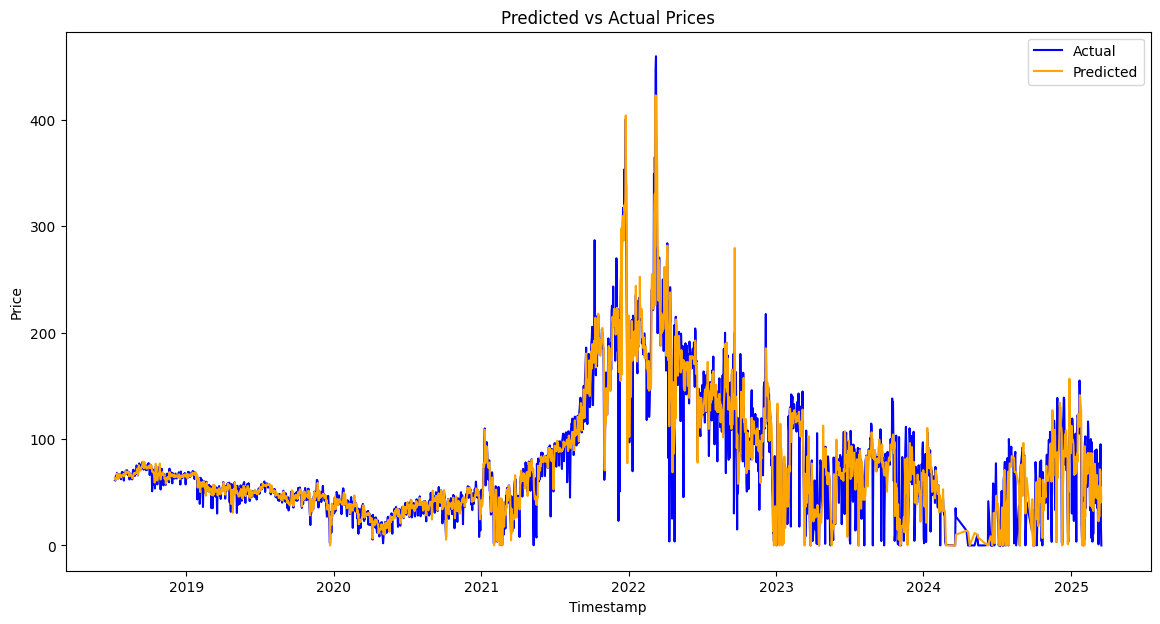

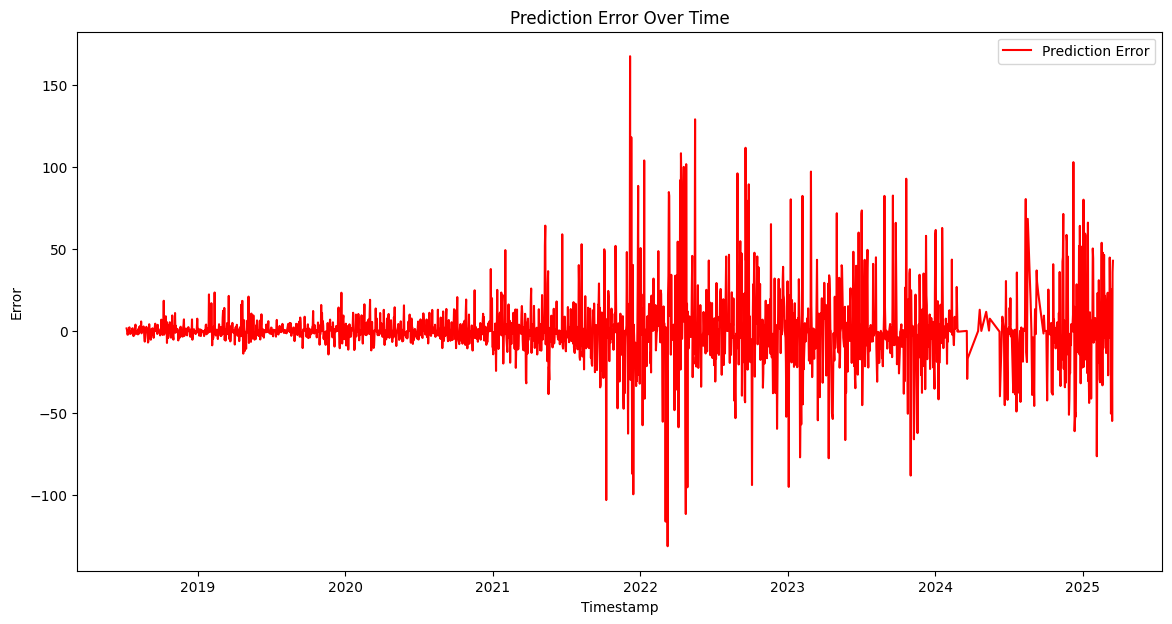

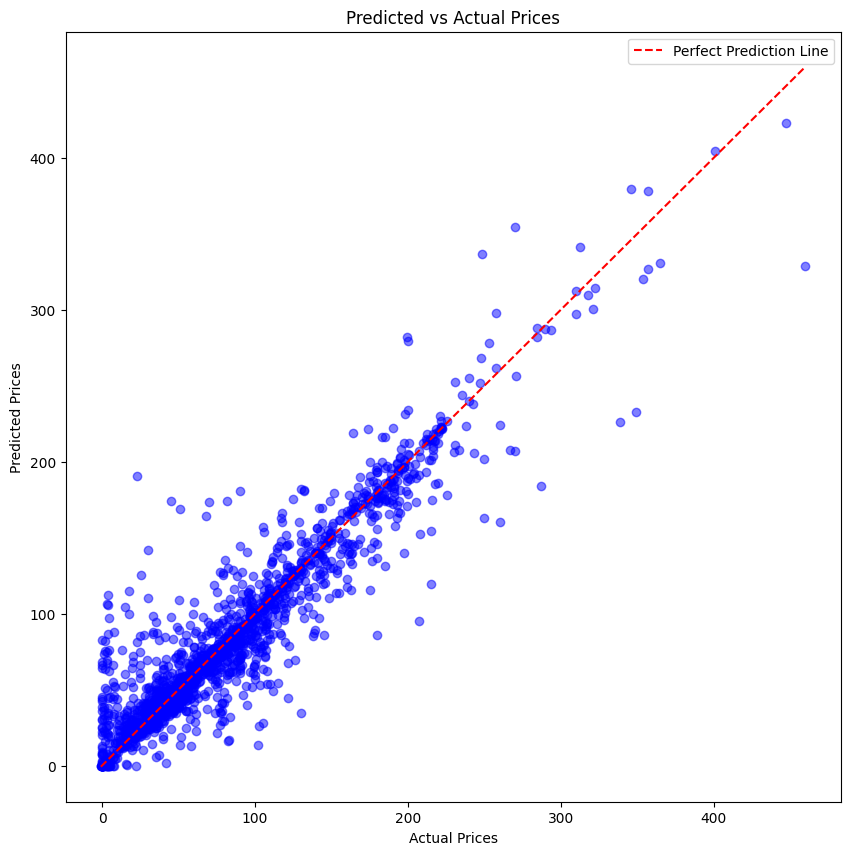

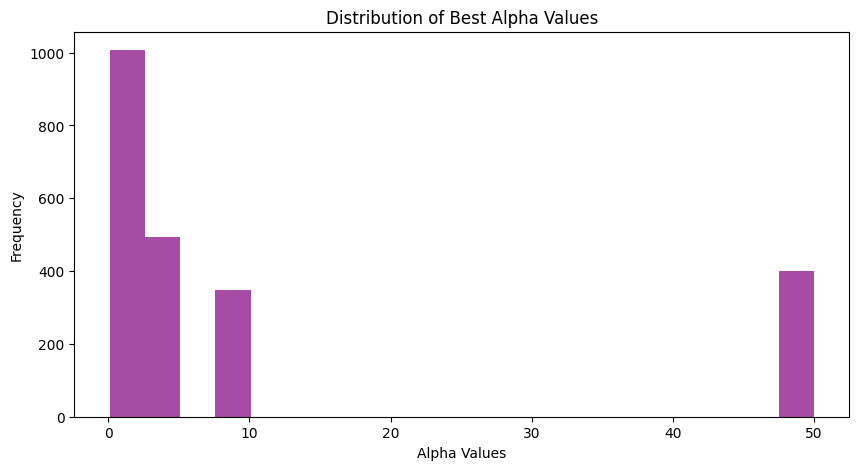

In [15]:
# Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Actual'], label='Actual', color='blue')
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'], label='Predicted', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()

# Plot error metrics
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'] - prediction_df['Actual'], label='Prediction Error', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Error')
plt.title('Prediction Error Over Time')
plt.legend()

# Plot a scatter plot of predicted vs actual prices with the intercept line
plt.figure(figsize=(10, 10))
plt.scatter(prediction_df['Actual'], prediction_df['Predicted'], alpha=0.5, color='blue')
plt.plot([prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         [prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.legend()

# plot a histogram of the best alpha values
plt.figure(figsize=(10, 5))
plt.hist(best_alpha_list, bins=20, color='purple', alpha=0.7)
plt.xlabel('Alpha Values')
plt.ylabel('Frequency')
plt.title('Distribution of Best Alpha Values')
plt.show()

Since the best Alpha value is 0.1, it will be the one used for later predictions

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from utils.matrix_builder import create_ta_feature_matrix, create_feature_matrix

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Debug parameter
DEBUG = False

if DEBUG:
    print("Debug mode is ON. Detailed output will be printed.")

# Load Database
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Define the Sliding Windows for this run
sliding_window = 10 # of days to train on (matrix rows)
lag_price_window = 3  # Window of the number of previous days as features (matrix columns)

training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

# Calculate number of sliding window models to train in the dataset
num_sliding_windows = len(df) - training_sliding_window
if DEBUG:
    print(f"Number of rows in the dataset: {len(df)}")

print(f"Number of sliding windows to train: {num_sliding_windows}")

# Display the first few rows of the DataFrame
# print(f"Database:\n{df.head()}")

# If you want to extend this to a full loop over multiple windows:
# Full sliding window loop example:
predictions_list = []
actuals_list = []
timestamps_list = []
best_alpha_list = []  # Initialize the list to store best alphas

model = Lasso(alpha=0.1, max_iter=2000, tol=1e-4)  # Initialize the model with a default alpha

for i in range(num_sliding_windows):
    if DEBUG:
        print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

    # Ensure we do not exceed the DataFrame length
    if i + training_sliding_window >= len(df):
        break  # Avoid index out of bounds
    
    sliding_window_set = df.iloc[i : i + training_sliding_window]
    
    # Create feature matrix and target variable for training
    X_train, y_train = create_ta_feature_matrix(sliding_window_set, lag_price_window)
    
    # Split for training and prediction
    X_train_fit = X_train.iloc[:-1]
    y_train_fit = y_train.iloc[:-1]

    X_to_predict = X_train.iloc[-1:]
    y_to_predict = y_train.iloc[-1]

    # Scale features for better convergence
    scaler = StandardScaler()
    X_train_fit_scaled = scaler.fit_transform(X_train_fit)
    X_to_predict_scaled = scaler.transform(X_to_predict)

    model.fit(X_train_fit_scaled, y_train_fit)
    y_predicted = model.predict(X_to_predict_scaled)
    
    # Add bounds checking to catch extreme predictions
    # high bound 1000, low bound 0
    if y_predicted[0] < 0:
        # set as 0, avoiding negative predictions
        y_predicted[0] = 0

    if abs(y_predicted[0]) > 1000:  # Reasonable price bounds
        continue  # Skip this alpha if prediction is unrealistic

    # Store results
    predictions_list.append(y_predicted[0])
    actuals_list.append(y_to_predict)
    if 'Datetime' in sliding_window_set.columns:
        timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
    else:
        timestamps_list.append(i + training_sliding_window - 1)

# Create final prediction DataFrame
prediction_df = pd.DataFrame({
    'Timestamp': timestamps_list,
    'Predicted': predictions_list,
    'Actual': actuals_list
})

# Calculate overall metrics
mse = mean_squared_error(actuals_list, predictions_list)
mae = mean_absolute_error(actuals_list, predictions_list)
r2 = r2_score(actuals_list, predictions_list)

print(f"Overall Mean Squared Error: {mse}")
print(f"Overall Mean Absolute Error: {mae}")
print(f"Overall R^2 Score: {r2}")

Number of sliding windows to train: 2249
Overall Mean Squared Error: 3362.64730622827
Overall Mean Absolute Error: 28.03976485497746
Overall R^2 Score: 0.014856428788662002


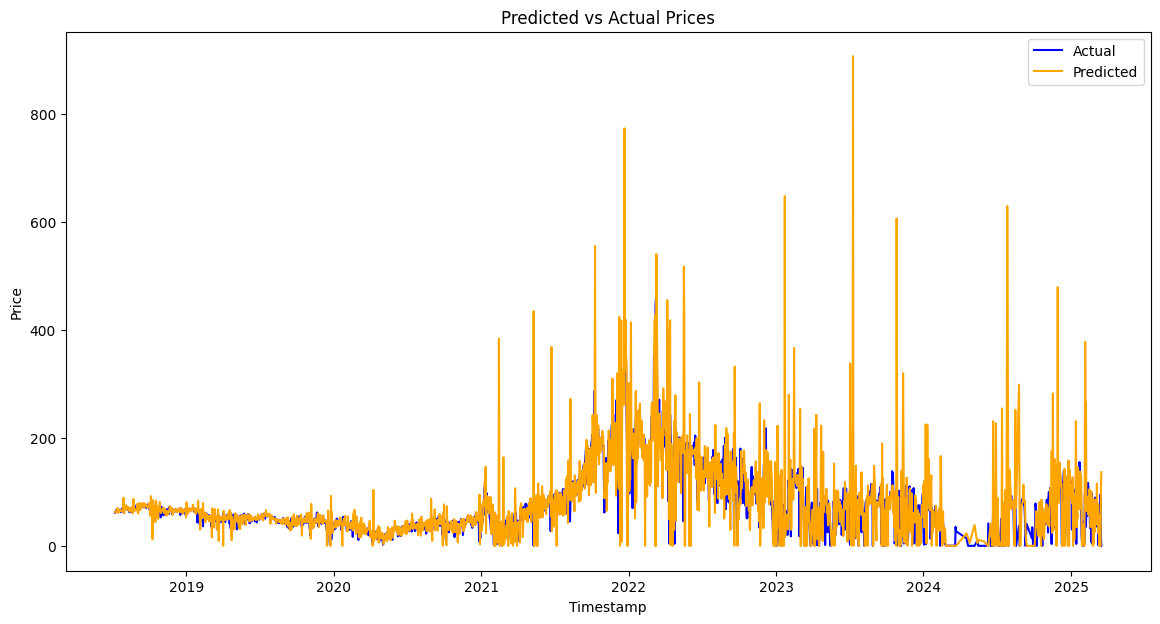

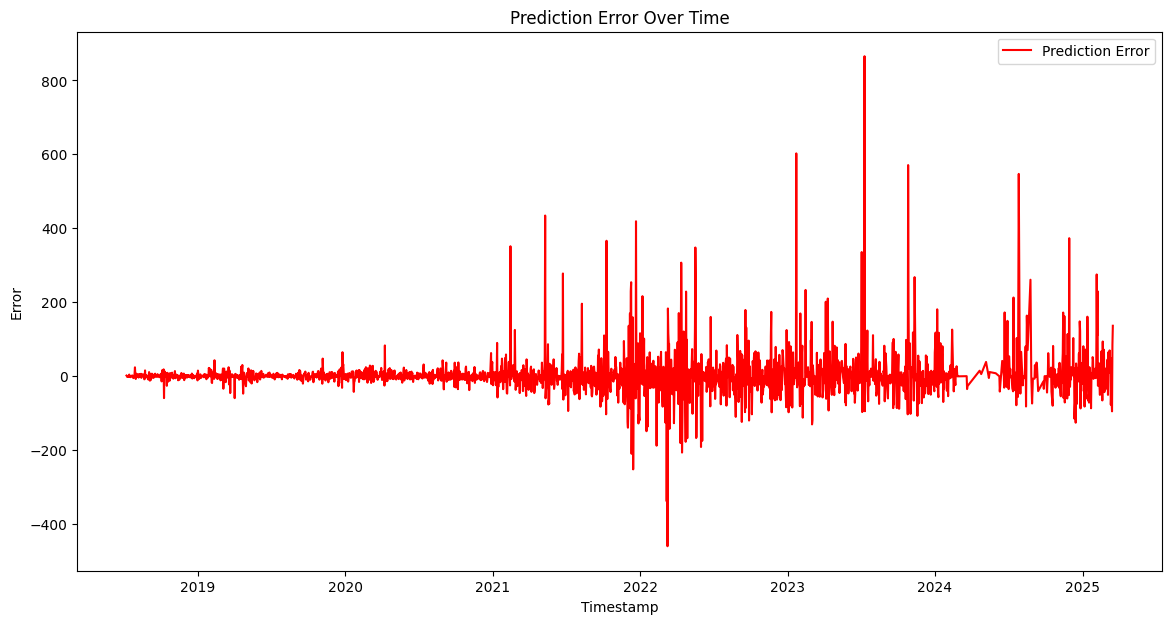

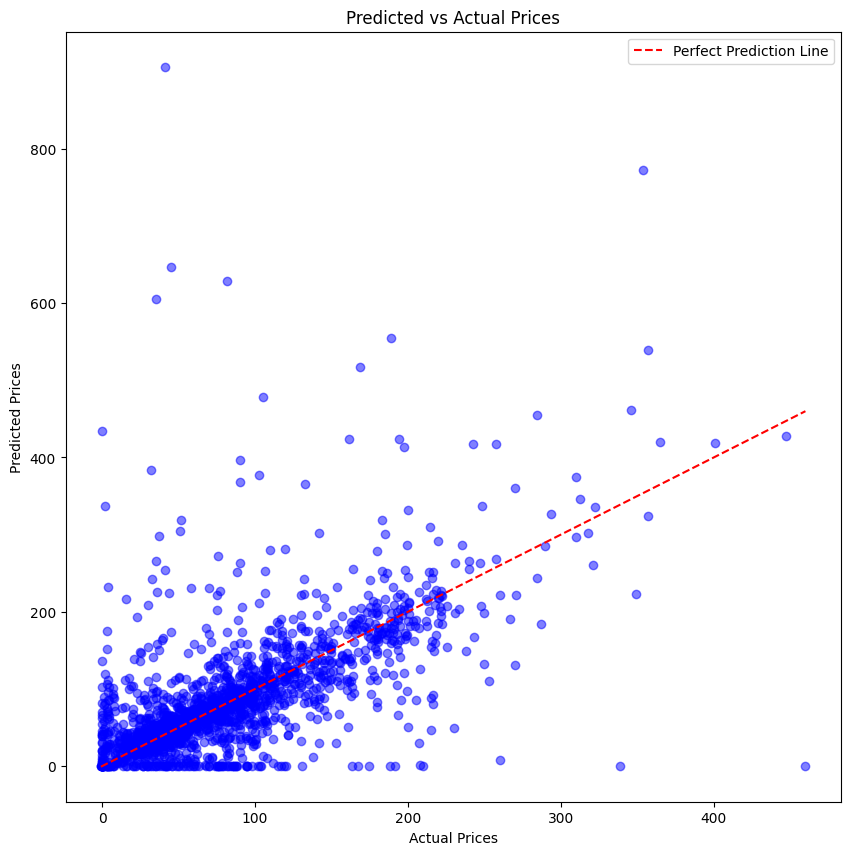

In [7]:
# Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Actual'], label='Actual', color='blue')
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'], label='Predicted', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()

# Plot error metrics
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'] - prediction_df['Actual'], label='Prediction Error', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Error')
plt.title('Prediction Error Over Time')
plt.legend()

# Plot a scatter plot of predicted vs actual prices with the intercept line
plt.figure(figsize=(10, 10))
plt.scatter(prediction_df['Actual'], prediction_df['Predicted'], alpha=0.5, color='blue')
plt.plot([prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         [prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.legend()